In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [22]:
df = pd.read_csv('Data/processed_hourly_Wh_data.csv')
df = df.set_index('DateTime')

df.index = pd.to_datetime(df.index)

In [23]:
df = df.drop(columns='Global_active_power')
df = df.iloc[8:]
df.head()

,Wh
DateTime,
2021-10-05 00:00:00,116.963280
2021-10-05 01:00:00,118.635140
2021-10-05 02:00:00,115.502219
2021-10-05 03:00:00,106.488098
2021-10-05 04:00:00,107.386719


<Axes: title={'center': 'Wh'}, xlabel='DateTime'>

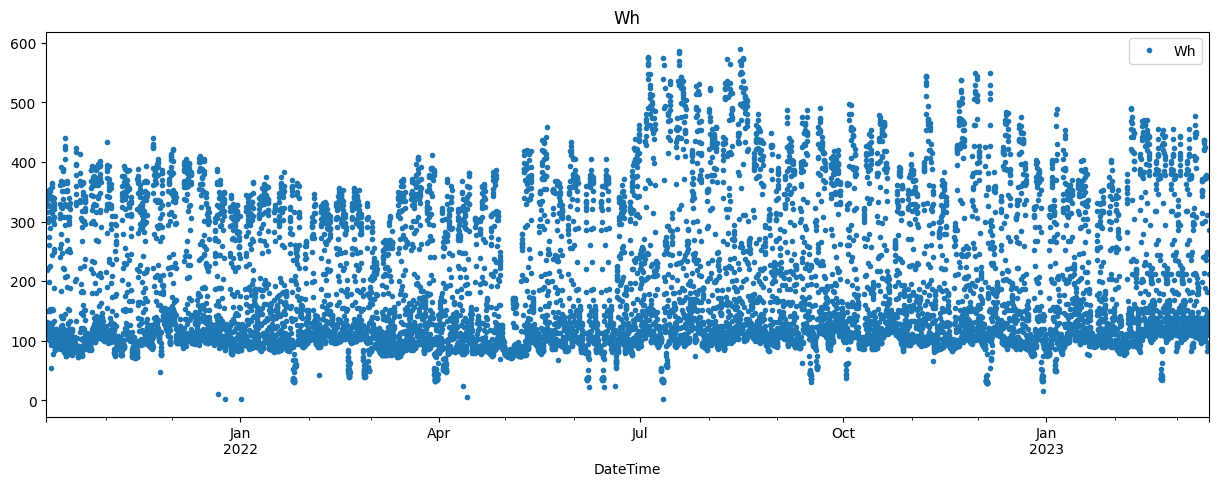

In [24]:
df.plot(
    style='.',
    figsize=(15,5),
    title='Wh'
)

## Outlier Removal

<Axes: ylabel='Frequency'>

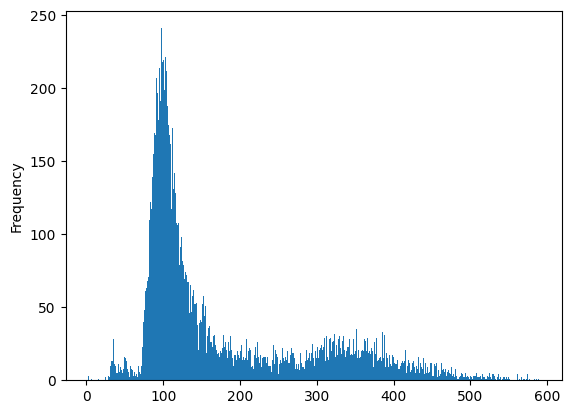

In [25]:
df['Wh'].plot(kind='hist', bins=500)

<Axes: xlabel='DateTime'>

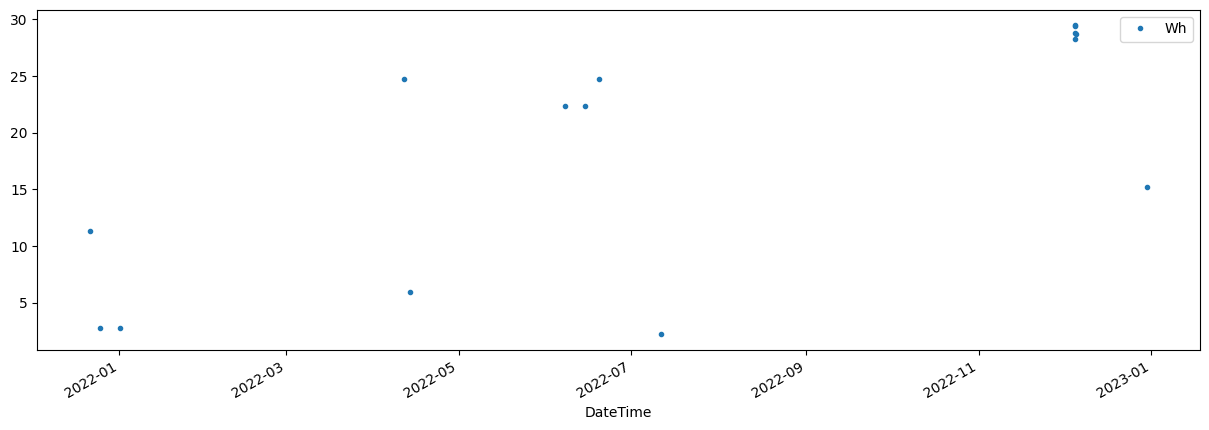

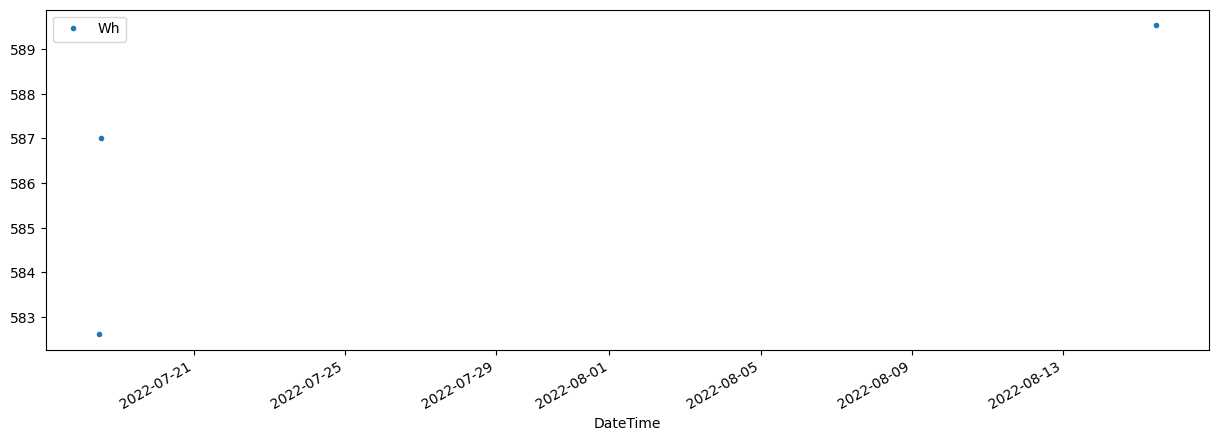

In [26]:
df.query('Wh < 30').plot(figsize=(15,5), style='.')
df.query('Wh > 580').plot(figsize=(15,5), style='.')

In [27]:
df =df.query('580 > Wh > 30').copy()

## Time Series Cross Validation

In [28]:
from sklearn.model_selection import TimeSeriesSplit

In [29]:
# tss = TimeSeriesSplit(n_splits=3)
tss = TimeSeriesSplit(n_splits=10)
df  = df.sort_index()

[    0     1     2 ... 11468 11469 11470] 
 [11471 11472 11473 ... 12615 12616 12617]


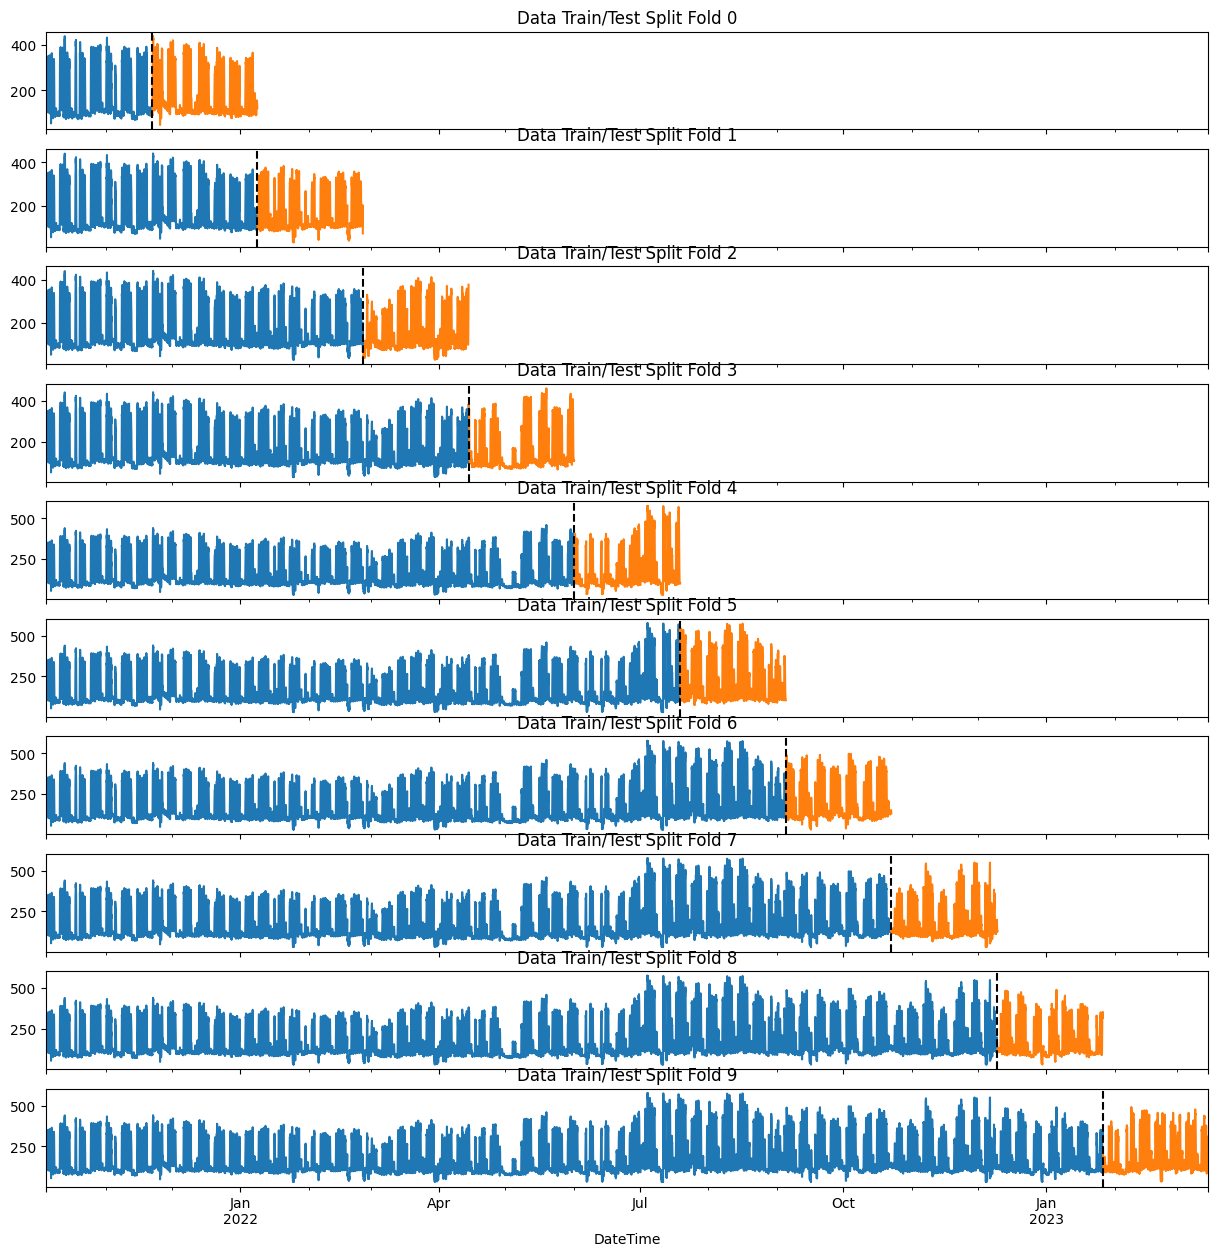

In [30]:
fig, axes = plt.subplots(10, 1, figsize=(15,15), sharex=True)

fold=0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Wh'].plot(ax=axes[fold],
                     label='Training set',
                     title=f'Data Train/Test Split Fold {fold}')
    test['Wh'].plot(ax=axes[fold], label='Test Set')
    axes[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

print(train_idx, '\n',val_idx)

## Forecasting Horizon

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Lag Features

In [12]:
def add_lags(df):
    target_map = df['Wh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    return df

df = add_lags(df)

## Train using Cross Validation

In [13]:
df.head()

,Wh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
DateTime,,,,,,,,,,,,
2021-10-05 00:00:00,116.963280,0,1,4,10,2021,278,5,40,NaN,NaN,NaN
2021-10-05 01:00:00,118.635140,1,1,4,10,2021,278,5,40,NaN,NaN,NaN
2021-10-05 02:00:00,115.502219,2,1,4,10,2021,278,5,40,NaN,NaN,NaN
2021-10-05 03:00:00,106.488098,3,1,4,10,2021,278,5,40,NaN,NaN,NaN
2021-10-05 04:00:00,107.386719,4,1,4,10,2021,278,5,40,NaN,NaN,NaN


In [14]:
df.tail() 
# Notice how lags are available in tails but not head, 
# the indexes in the head do not have enough data to generate lags

,Wh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
DateTime,,,,,,,,,,,,
2023-03-15 07:00:00,89.057437,7,2,1,3,2023,74,15,11,235.859787,198.790546,89.057437
2023-03-15 08:00:00,96.547518,8,2,1,3,2023,74,15,11,375.623297,297.677646,96.547518
2023-03-15 09:00:00,132.531257,9,2,1,3,2023,74,15,11,377.646371,351.859060,132.531257
2023-03-15 10:00:00,212.846685,10,2,1,3,2023,74,15,11,373.178134,342.275994,212.846685
2023-03-15 11:00:00,286.483606,11,2,1,3,2023,74,15,11,244.070063,349.835701,286.483606


In [15]:
import optuna

# tss = TimeSeriesSplit(n_splits=, test_size=24*7, gap=24)
# df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Wh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    def objective(trial):
        param = {
            'objective': 'reg:squarederror',
            'booster': 'gbtree',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'early_stopping_rounds': 50
        }

        reg = xgb.XGBRegressor(**param)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)
        y_pred = reg.predict(X_test)
        return np.sqrt(mean_squared_error(y_test, y_pred))

    study_name = f"fold_{fold}_study"  # Unique name for each fold
    storage_name = "sqlite:///optuna_studies.db"  # SQLite database to store studies
    study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name, load_if_exists=True)
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    reg = xgb.XGBRegressor(**best_params, objective='reg:squarederror', booster='gbtree')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

C:\Users\Ilham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-10 11:09:04,485] A new study created in RDB with name: fold_0_study
[I 2025-05-10 11:09:05,540] Trial 0 finished with value: 57.79665371064074 and parameters: {'n_estimators': 928, 'max_depth': 9, 'learning_rate': 0.19019864760132768, 'subsample': 0.7236838824533218, 'colsample_bytree': 0.9823409920391935}. Best is trial 0 with value: 57.79665371064074.
[I 2025-05-10 11:09:05,915] Trial 1 finished with value: 56.25754463510452 and parameters: {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.16694827598990292, 'subsample': 0.9921245345057033, 'colsample_bytree': 0.8419768037628322}. Best is trial 1 with value: 56.25754463510452.
[

[0]	validation_0-rmse:96.69885	validation_1-rmse:103.56173
[100]	validation_0-rmse:27.81101	validation_1-rmse:54.50486
[200]	validation_0-rmse:20.67219	validation_1-rmse:55.85229
[229]	validation_0-rmse:19.38681	validation_1-rmse:55.39682


[I 2025-05-10 11:09:20,137] Using an existing study with name 'fold_0_study' instead of creating a new one.
[I 2025-05-10 11:09:20,509] Trial 50 finished with value: 32.623789604047964 and parameters: {'n_estimators': 647, 'max_depth': 9, 'learning_rate': 0.24555094322020218, 'subsample': 0.5884097784915199, 'colsample_bytree': 0.9055211268146532}. Best is trial 50 with value: 32.623789604047964.
[I 2025-05-10 11:09:20,814] Trial 51 finished with value: 28.307430945320874 and parameters: {'n_estimators': 873, 'max_depth': 9, 'learning_rate': 0.27493838665487547, 'subsample': 0.5299556855015715, 'colsample_bytree': 0.9087673791892338}. Best is trial 51 with value: 28.307430945320874.
[I 2025-05-10 11:09:21,115] Trial 52 finished with value: 35.05788522578641 and parameters: {'n_estimators': 985, 'max_depth': 9, 'learning_rate': 0.2750309041979788, 'subsample': 0.5904722834528331, 'colsample_bytree': 0.9326491437097942}. Best is trial 51 with value: 28.307430945320874.
[I 2025-05-10 11:0

KeyboardInterrupt: 

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 66.0504
Fold scores:[59.835468949180694, 40.79287421325415, 88.24418818656515, 66.89245866641755, 65.87288846920053, 73.17707164663034, 89.7072913827176, 73.90045248813226, 59.86679071422097, 42.214572009588366]


In [ ]:
df.index.max()

Timestamp('2023-03-15 11:00:00')

In [ ]:
future = pd.date_range('2023-03-16', '2023-03-30', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features

,Wh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2023-03-16 00:00:00,NaN,0,3,1,3,2023,75,16,11,112.653415,104.538126,109.836119,True
2023-03-16 01:00:00,NaN,1,3,1,3,2023,75,16,11,93.686505,104.439532,108.682066,True
2023-03-16 02:00:00,NaN,2,3,1,3,2023,75,16,11,92.577086,107.588873,107.895241,True
2023-03-16 03:00:00,NaN,3,3,1,3,2023,75,16,11,90.141054,100.002195,107.807711,True
2023-03-16 04:00:00,NaN,4,3,1,3,2023,75,16,11,91.368685,101.058188,109.724763,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 20:00:00,NaN,20,2,1,3,2023,88,29,13,NaN,NaN,NaN,True
2023-03-29 21:00:00,NaN,21,2,1,3,2023,88,29,13,NaN,NaN,NaN,True
2023-03-29 22:00:00,NaN,22,2,1,3,2023,88,29,13,NaN,NaN,NaN,True
2023-03-29 23:00:00,NaN,23,2,1,3,2023,88,29,13,NaN,NaN,NaN,True


In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: >

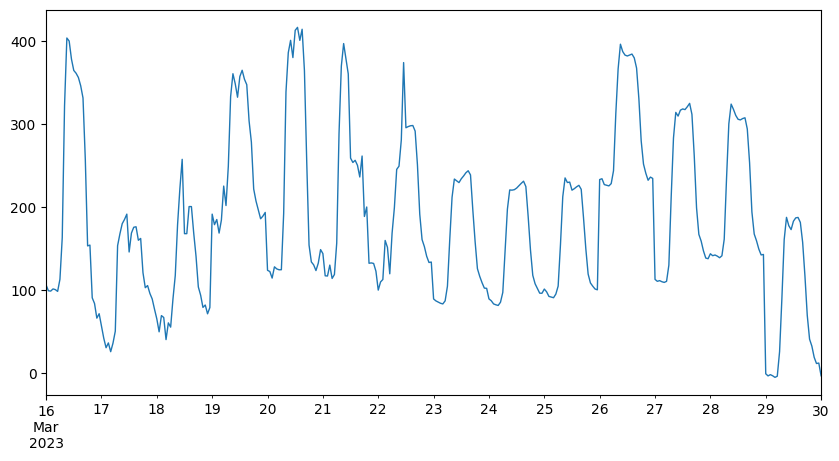

In [ ]:
future_w_features['pred'].plot(
    figsize= (10,5),
    ms=1, lw=1
)

In [1]:
import xgboost

build_info = xgboost.build_info()
for name in sorted(build_info.keys()):
    print(f'{name}: {build_info[name]}')

BUILTIN_PREFETCH_PRESENT: False
CUDA_VERSION: [12, 5]
DEBUG: False
MM_PREFETCH_PRESENT: True
THRUST_VERSION: [2, 6, 1]
USE_CUDA: True
USE_DLOPEN_NCCL: False
USE_FEDERATED: False
USE_NCCL: False
USE_OPENMP: True
USE_RMM: False
libxgboost: C:\Users\Ilham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\lib\xgboost.dll
